In [1]:
! pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 4.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from umap.umap_ import UMAP
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pytorch_metric_learning import losses

2024-04-12 22:58:40.109232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 22:58:40.109357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 22:58:40.238447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set global parameters
num_epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

print(device)

cuda


### Data loaders

In [4]:
# Load and preprocess CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the size for the train and validation splits
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Calculate the class weights
class_counts = [0] * 10  # 10 classes in CIFAR10
for _, label in train_dataset:
    class_counts[label] += 1

total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
# Create a list of sample weights based on class weights
sample_weights = [class_weights[label] for _, label in train_dataset]
# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

# Create data loaders for training, validation, and test
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 32075879.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Checking distribution of data

In [5]:
# Check class distribution in each batch
num_classes = 10  # Assuming 10 classes in CIFAR10
batch_class_counts = [0] * num_classes

for batch_images, batch_labels in train_loader:
    for label in batch_labels:
        batch_class_counts[label] += 1

    # Reset batch class counts for the next batch
    batch_class_counts = [0] * num_classes

# Print overall class distribution in the training dataset
print("\nOverall class distribution in the training dataset:")
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count}")


Overall class distribution in the training dataset:
Class 0: 4038
Class 1: 4011
Class 2: 3951
Class 3: 4033
Class 4: 3973
Class 5: 3966
Class 6: 4028
Class 7: 3975
Class 8: 3984
Class 9: 4041


# Help functions

### KNN test function

In [6]:
# Extract features from the images using the pre-trained model
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.cuda()
            features_batch = model(images).cpu().numpy()
            features.append(features_batch)
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels



# Test the model on original test data using KNN
def test_model_knn(model, knn_classifier, dataloader):
    model.eval()
    features, labels = extract_features(model, dataloader)
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on original test data using KNN: {accuracy:.2f}%")



# Test the model on adversarial test data using KNN
def test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device):
    model.eval()
    # Convert adversarial_images to tensor
    adversarial_images_tensor = torch.tensor(adversarial_images, dtype=torch.float32).to(device)
    # Detach the tensor from the computation graph
    features = model(adversarial_images_tensor).detach().cpu().numpy()
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on adversarial test data using KNN: {accuracy:.2f}%")

### Visualize feature map

In [7]:
def plot_umap(model, dataloader, device):
    # Set model to evaluation mode
    model.eval()

    # Define a function to get embeddings
    def get_embeddings(model, dataloader):
        embeddings = []
        labels = []
        with torch.no_grad():
            for images, targets in dataloader:
                images = images.to(device)
                outputs = model(images)
                embeddings.append(outputs.cpu().numpy())
                labels.append(targets.cpu().numpy())
        embeddings = np.concatenate(embeddings)
        labels = np.concatenate(labels)
        return embeddings, labels

    # Get embeddings from the dataloader
    embeddings_test, labels_test = get_embeddings(model, dataloader)

    # Use UMAP to reduce dimensionality
    reducer = UMAP()
    embedding_umap_test = reducer.fit_transform(embeddings_test)

    # Plot UMAP visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_umap_test[:, 0], embedding_umap_test[:, 1], c=labels_test, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title('UMAP Visualization of original data')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

### Generate adverserial samples

In [8]:
def combine_fgsm_and_noise(model, images, labels, eps, noise_factor):
    # Generate adversarial images using CleverHans's Fast Gradient Sign Method (FGSM)
    attack_images = fast_gradient_method(model, images, eps, np.inf, targeted=False, y=labels)
    attack_images = attack_images.detach()

    # Add Gaussian noise
    attack_images_np = attack_images.cpu().numpy()
    attack_images_np += noise_factor * np.random.normal(loc=0, scale=1, size=attack_images_np.shape)
    attack_images_np = np.clip(attack_images_np, 0, 1)
    attack_images_with_noise = torch.tensor(attack_images_np, requires_grad=False).to(device)

    return attack_images_with_noise

# Parameters for FGSM and noise
eps = 0.1
noise_factor = 0.05

# 1. Original dataset/Cross Entropy

### 1.1. Train original data/Cross entropy

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            train_total += labels.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Append to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Training Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


Epoch [1/25], Training Loss: 0.8763, Validation Loss: 0.8063
Epoch [2/25], Training Loss: 0.5326, Validation Loss: 0.7551
Epoch [3/25], Training Loss: 0.4174, Validation Loss: 0.6757
Epoch [4/25], Training Loss: 0.3298, Validation Loss: 0.7458
Epoch [5/25], Training Loss: 0.2732, Validation Loss: 0.6608
Epoch [6/25], Training Loss: 0.2208, Validation Loss: 0.7092
Epoch [7/25], Training Loss: 0.1848, Validation Loss: 0.7030
Epoch [8/25], Training Loss: 0.1545, Validation Loss: 0.7256
Epoch [9/25], Training Loss: 0.1325, Validation Loss: 0.7993
Epoch [10/25], Training Loss: 0.1219, Validation Loss: 0.8469
Epoch [11/25], Training Loss: 0.1109, Validation Loss: 0.7994
Epoch [12/25], Training Loss: 0.0975, Validation Loss: 0.7885
Epoch [13/25], Training Loss: 0.0845, Validation Loss: 0.8191
Epoch [14/25], Training Loss: 0.0746, Validation Loss: 0.8505
Epoch [15/25], Training Loss: 0.0722, Validation Loss: 0.8569
Epoch [16/25], Training Loss: 0.0679, Validation Loss: 0.8815
Epoch [17/25], Tr

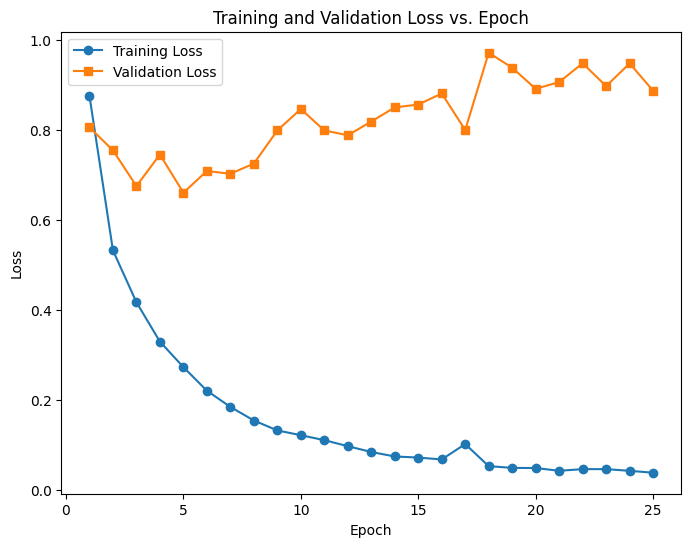

In [10]:
# Setup
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

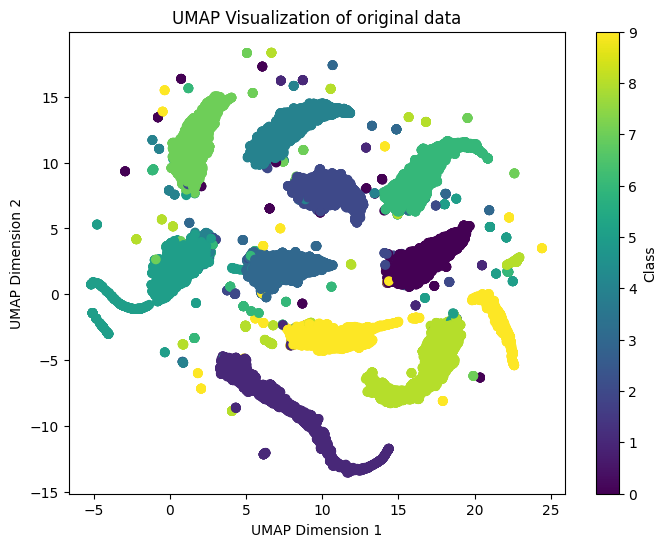

In [11]:
# Call the function to extract and visualize features
plot_umap(model, train_loader, device)

### 1.2. FGSM

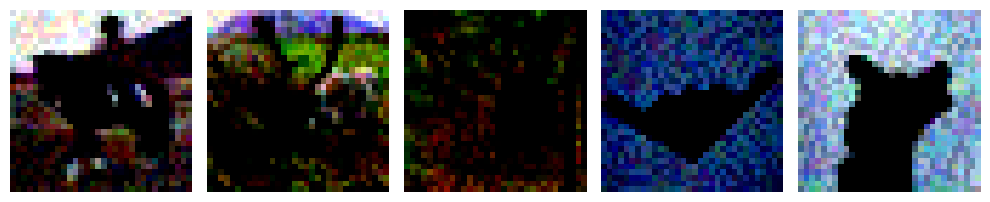

In [12]:
model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

# Display some adversarial images
num_images = 5
indices = np.random.choice(len(adversarial_images), num_images, replace=False)
plt.figure(figsize=(10, 4))
for i, index in enumerate(indices):
    plt.subplot(1, num_images, i+1)
    plt.imshow(np.transpose(adversarial_images[index], (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1.3. Test original data/Cross entropy

In [13]:
train_features, train_labels = extract_features(model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(model, knn_classifier, test_loader)
test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device)

Accuracy on original test data using KNN: 80.72%
Accuracy on adversarial test data using KNN: 11.12%


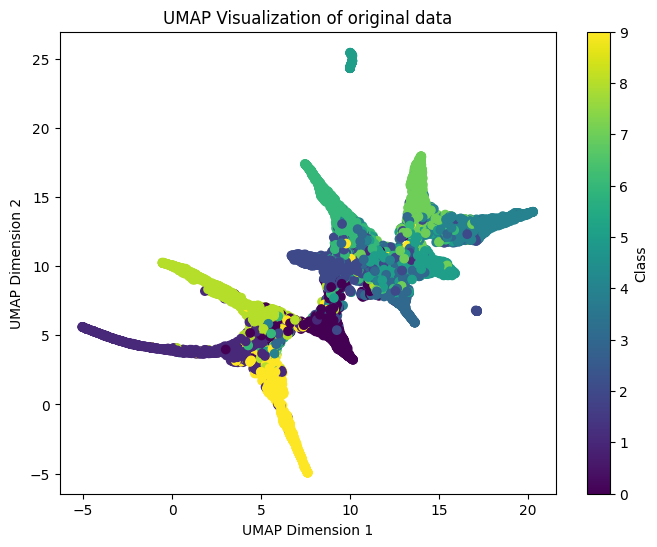

In [14]:
# Call the function to extract and visualize features
plot_umap(model, test_loader, device)

# 2. Agumented data/Cross entropy

### 2.1. Train agumented data/Cross entropy

In [15]:
# Function to apply FGSM attack with 50% probability to each batch
def apply_fgsm(model, images, labels, criterion, eps):
    # Enable gradients for images
    images.requires_grad = True

    # Perform FGSM attack only if gradients are enabled
    if images.requires_grad:
        outputs = model(images)
        model.zero_grad()
        cost = criterion(outputs, labels)
        cost.backward()
        attack_images = images + eps * images.grad.sign()
        attack_images = torch.clamp(attack_images, 0, 1)
    else:
        attack_images = images

    return attack_images

In [16]:
# Modified training function to apply FGSM with 50% probability
def train_with_fgsm(model, train_loader, val_loader, criterion, optimizer, device, epochs, eps=0.1):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Apply FGSM attack with 50% probability
            if torch.rand(1) < 0.5:
                images = apply_fgsm(model, images, labels, criterion, eps)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)

        # Validation loop
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Note: No FGSM attack is applied during validation
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, 'o-', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, 's-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Training Loss: 1.4456, Validation Loss: 1.0864
Epoch [2/25], Training Loss: 1.1464, Validation Loss: 0.8473
Epoch [3/25], Training Loss: 0.9927, Validation Loss: 0.7648
Epoch [4/25], Training Loss: 0.8746, Validation Loss: 0.7485
Epoch [5/25], Training Loss: 0.8330, Validation Loss: 0.7847
Epoch [6/25], Training Loss: 0.7895, Validation Loss: 0.6866
Epoch [7/25], Training Loss: 0.6985, Validation Loss: 0.6803
Epoch [8/25], Training Loss: 0.6228, Validation Loss: 0.6652
Epoch [9/25], Training Loss: 0.5952, Validation Loss: 0.7329
Epoch [10/25], Training Loss: 0.5988, Validation Loss: 0.6760
Epoch [11/25], Training Loss: 0.5454, Validation Loss: 0.6933
Epoch [12/25], Training Loss: 0.5499, Validation Loss: 0.6861
Epoch [13/25], Training Loss: 0.5165, Validation Loss: 0.6820
Epoch [14/25], Training Loss: 0.4804, Validation Loss: 0.7043
Epoch [15/25], Training Loss: 0.4765, Validation Loss: 0.7340
Epoch [16/25], Training Loss: 0.4201, Validation Loss: 0.7496
Epoch [17/25], Tr

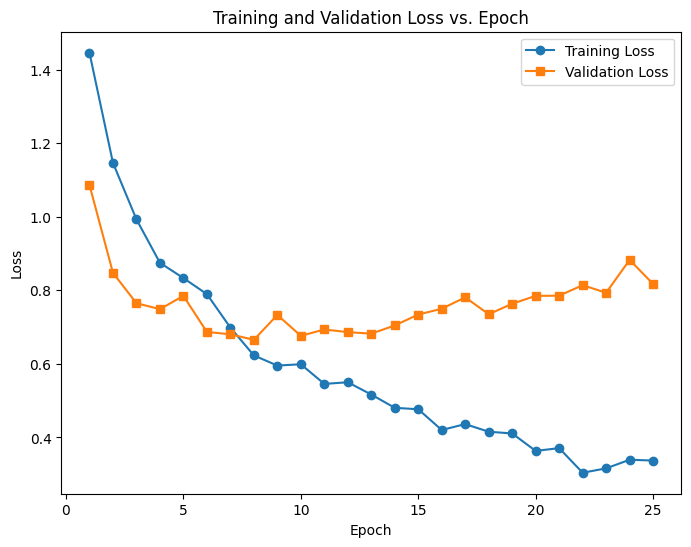

In [17]:
# Setup and Retrain
new_model = resnet18(pretrained=True)
num_features = new_model.fc.in_features
new_model.fc = nn.Linear(num_features, 10)
new_model = new_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

# Train
train_losses = train_with_fgsm(new_model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

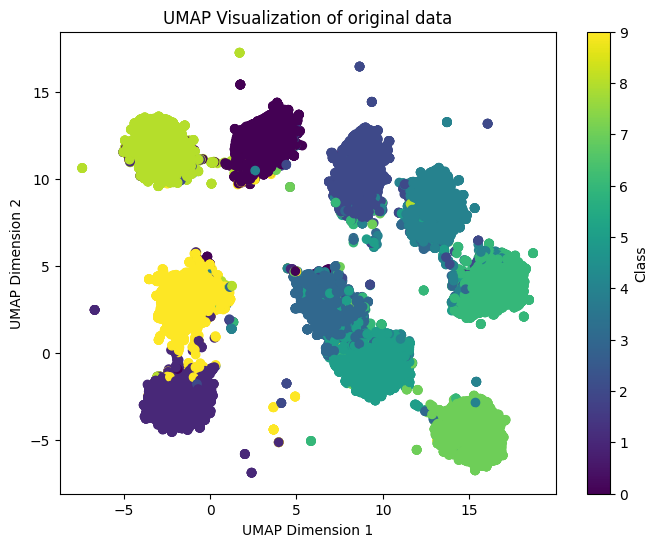

In [18]:
# Call the function to extract and visualize features
plot_umap(new_model, train_loader, device)

### 2.2. FGSM

In [19]:
new_model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(new_model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

### 2.3. Test agumented data/Cross entropy

In [20]:
# KNN test
train_features, train_labels = extract_features(new_model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(new_model, knn_classifier, test_loader)
test_model_adversarial_knn(new_model, knn_classifier, adversarial_images, labels, device)

Accuracy on original test data using KNN: 75.27%
Accuracy on adversarial test data using KNN: 25.85%


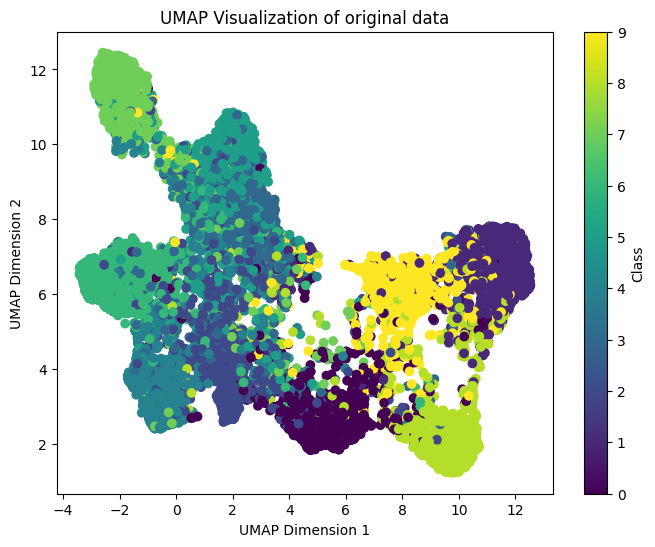

In [21]:
# Call the function to extract and visualize features
plot_umap(new_model, test_loader, device)

# 3. Original data/Circle loss

### 3.1. Optimum values of the Circle loss

In [22]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(images)
            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            train_total += labels.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                embeddings = model(images)
                loss = criterion(embeddings, labels)
                val_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Append to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Training Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

In [23]:
def greedy_search(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, m_values, gamma_values):
    best_accuracy = 0.0
    best_m = None
    best_gamma = None

    for m in m_values:
        for gamma in gamma_values:
            criterion = losses.CircleLoss(m=m, gamma=gamma)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)
            accuracy = calculate_accuracy(model, val_loader, device)  # You need to define this function
            print(f"m={m}, gamma={gamma}, Validation Accuracy: {accuracy}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_m = m
                best_gamma = gamma

    print(f"Best m={best_m}, gamma={best_gamma}, Best Validation Accuracy: {best_accuracy}")
    

    
def calculate_accuracy(model, dataloader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total



In [24]:
# # Define the search space for m and gamma
# m_values = [0.2, 0.4, 0.6]
# gamma_values = [50, 80, 100]

# # Perform greedy search
# greedy_search(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, m_values, gamma_values)

### 3.2. Train original data/Circle loss

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Training Loss: 58.3209, Validation Loss: 58.5173
Epoch [2/25], Training Loss: 58.2194, Validation Loss: 58.9066
Epoch [3/25], Training Loss: 58.1226, Validation Loss: 58.7658
Epoch [4/25], Training Loss: 58.1630, Validation Loss: 58.9599
Epoch [5/25], Training Loss: 58.2255, Validation Loss: 59.3864
Epoch [6/25], Training Loss: 58.0870, Validation Loss: 58.8274
Epoch [7/25], Training Loss: 58.0413, Validation Loss: 58.6889
Epoch [8/25], Training Loss: 58.2190, Validation Loss: 58.6105
Epoch [9/25], Training Loss: 58.2358, Validation Loss: 58.7277
Epoch [10/25], Training Loss: 58.2718, Validation Loss: 58.4793
Epoch [11/25], Training Loss: 58.2434, Validation Loss: 58.9301
Epoch [12/25], Training Loss: 58.2264, Validation Loss: 58.9545
Epoch [13/25], Training Loss: 58.1838, Validation Loss: 58.9288
Epoch [14/25], Training Loss: 58.2252, Validation Loss: 58.8914
Epoch [15/25], Training Loss: 58.2424, Validation Loss: 58.4696
Epoch [16/25], Training Loss: 58.1397, Validation

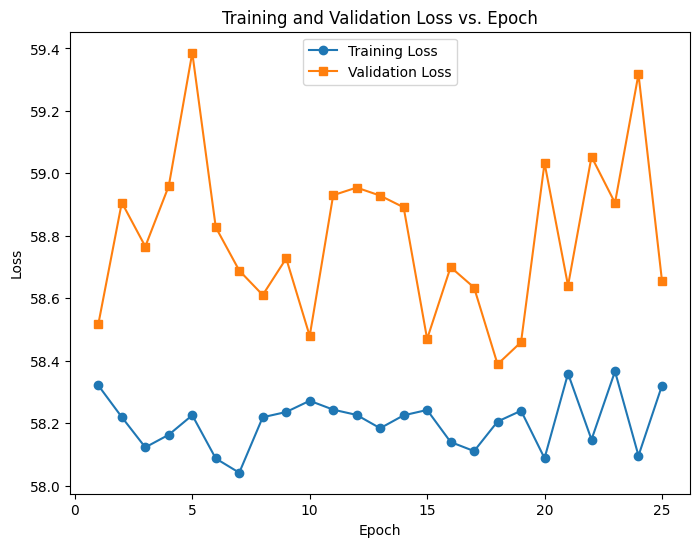

In [25]:
# Setup and Retrain
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, 128)

    def forward(self, x):
        return self.resnet(x)

new_model2 = Net()
new_model2.eval()
new_model2 = new_model2.to(device)

criterion = losses.CircleLoss(m=0.4, gamma=80)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses_circle = train(new_model2, train_loader, val_loader, criterion, optimizer, device, num_epochs)

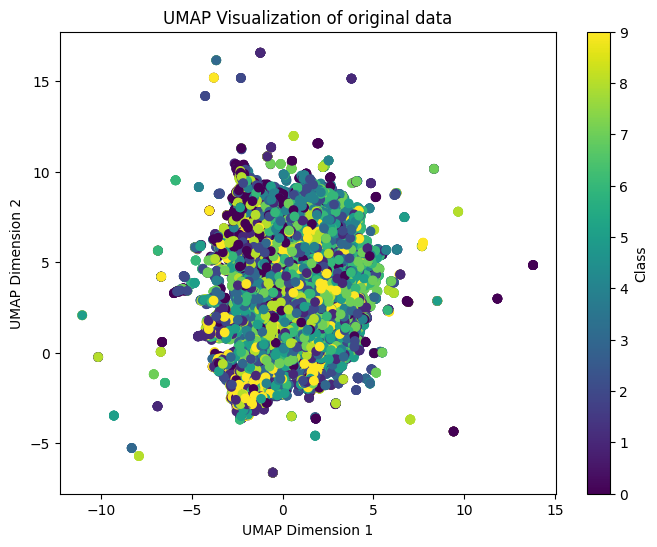

In [26]:
# Call the function to extract and visualize features
plot_umap(new_model2, train_loader, device)

### 3.3. FGSM

In [27]:
new_model2.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(new_model2, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

### 3.4. Test original data/Circle loss

In [28]:
# KNN test
train_features, train_labels = extract_features(new_model2, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)


test_model_knn(new_model2, knn_classifier, test_loader)
test_model_adversarial_knn(new_model2, knn_classifier, adversarial_images, labels, device)

Accuracy on original test data using KNN: 27.79%
Accuracy on adversarial test data using KNN: 14.04%


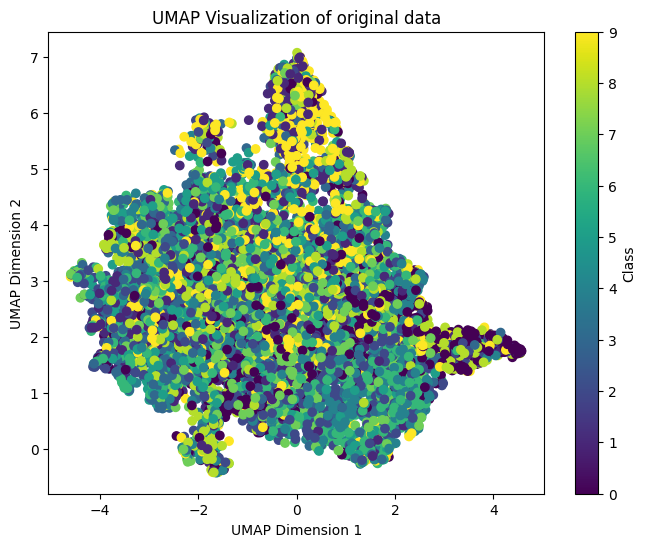

In [29]:
# Call the function to extract and visualize features
plot_umap(new_model2, test_loader, device)